In [1]:
import tensorflow as tf
import os

# Enable memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ GPU detected: {gpus}")
        print(f"✅ Memory growth enabled")
    except RuntimeError as e:
        print(e)
else:
    print("⚠️ No GPU detected, using CPU")

# Enable XLA
tf.config.optimizer.set_jit(True)
print("✅ XLA JIT compiler enabled")


2025-10-06 13:49:00.186537: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-06 13:49:00.248200: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-06 13:49:01.491760: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


✅ GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ Memory growth enabled
✅ XLA JIT compiler enabled


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

print("✅ Libraries imported")


✅ Libraries imported


In [3]:
# Dataset configuration
image_size = (224, 224)
batch_size = 64
seed = 42
dataset_path = 'Waste_Segregation_DatasetV2/'

print(f"Image size: {image_size}")
print(f"Batch size: {batch_size}")


Image size: (224, 224)
Batch size: 64


In [4]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.15),
    tf.keras.layers.RandomContrast(0.15),
], name="data_augmentation")

print("✅ Data augmentation configured")


✅ Data augmentation configured


I0000 00:00:1759738743.487610   31844 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6166 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [5]:
# Load full dataset
full_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=seed
)

# Get class names
class_names = full_dataset.class_names
num_classes = len(class_names)
print(f"✅ Classes: {class_names}")
print(f"Number of classes: {num_classes}")

# Calculate dataset size
dataset_size = tf.data.experimental.cardinality(full_dataset).numpy()
print(f"Total batches: {dataset_size}")

# Split: 70% train, 15% validation, 15% test
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset = full_dataset.take(train_size)
remaining = full_dataset.skip(train_size)
val_dataset = remaining.take(val_size)
test_dataset = remaining.skip(val_size)

print(f"✅ Train batches: {train_size}")
print(f"✅ Validation batches: {val_size}")
print(f"✅ Test batches: {test_size}")


Found 6228 files belonging to 4 classes.
✅ Classes: ['general_trash', 'hazardous', 'organic', 'recyclable']
Number of classes: 4
Total batches: 98
✅ Train batches: 68
✅ Validation batches: 14
✅ Test batches: 16


In [6]:
# Normalization (simple 0-1 scaling)
normalization_layer = tf.keras.layers.Rescaling(1./255)

def prepare_dataset(ds, augment=False):
    # Normalize
    ds = ds.map(lambda x, y: (normalization_layer(x), y),
                num_parallel_calls=tf.data.AUTOTUNE)

    # Augment training data only
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=tf.data.AUTOTUNE)

    # Prefetch
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

train_dataset = prepare_dataset(train_dataset, augment=True)
val_dataset = prepare_dataset(val_dataset, augment=False)
test_dataset = prepare_dataset(test_dataset, augment=False)

print("✅ Datasets prepared")


✅ Datasets prepared


## Optional
> If dataset is imbalanced, alter `model.fit()`

In [7]:
# Calculate class weights to handle imbalanced dataset
# Skip this cell if dataset is balanced, or run to check distribution

from sklearn.utils import class_weight

# You'll need to extract labels - this is a helper
def get_labels(dataset):
    labels = []
    for _, label_batch in dataset:
        labels.extend(np.argmax(label_batch.numpy(), axis=1))
    return np.array(labels)

# Extract train labels
train_labels = get_labels(train_dataset.unbatch().batch(batch_size))

# Calculate weights
class_weights_array = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights_array)}

print(f"Class weights: {class_weights_dict}")
print("✅ Use class_weights_dict in model.fit() if needed")


2025-10-06 13:49:06.103655: I external/local_xla/xla/service/service.cc:163] XLA service 0x7fe5c800c1b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-06 13:49:06.103689: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-10-06 13:49:06.127895: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91301
I0000 00:00:1759738746.153116   32025 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-10-06 13:49:11.467082: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


Class weights: {0: 0.9569041336851363, 1: 1.082587064676617, 2: 1.0177736202057999, 3: 0.9535495179666958}
✅ Use class_weights_dict in model.fit() if needed


2025-10-06 13:49:14.548863: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Build

In [8]:
# Build simple CNN from scratch
model = Sequential([
    # Block 1
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 4
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Classification head
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
], name='custom_cnn')

print("✅ Custom CNN model created")
model.summary()


/home/akshat/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


✅ Custom CNN model created


Model: "custom_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 27,002,148 (103.01 MB)

 Trainable params: 26,998,692 (102.99 MB)

 Non-trainable params: 3,456 (13.50 KB)

# Compile

In [9]:
# Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Model compiled")
print(f"Learning rate: 1e-3")


✅ Model compiled
Learning rate: 1e-3


# Callbacks

In [10]:
# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),

    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=4,
        min_lr=1e-7,
        mode='max',
        verbose=1
    ),

    ModelCheckpoint(
        'best_waste_cnn.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

print("✅ Callbacks configured")


✅ Callbacks configured


# Train

In [11]:
# Train model
epochs = 60

print("=" * 50)
print("TRAINING CUSTOM CNN FROM SCRATCH")
print("=" * 50)

history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1
)

print("✅ Training complete")


TRAINING CUSTOM CNN FROM SCRATCH
Epoch 1/60


2025-10-06 13:49:22.517878: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-10-06 13:49:22.983891: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-06 13:49:25.221999: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-06 13:49:25.754609: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local m

 3/68 ━━━━━━━━━━━━━━━━━━━━ 30s 469ms/step - accuracy: 0.2865 - loss: 1.9364

2025-10-06 13:49:52.377458: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


30/68 ━━━━━━━━━━━━━━━━━━━━ 9s 260ms/step - accuracy: 0.3695 - loss: 1.7497 

Invalid SOS parameters for sequential JPEG


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.3857 - loss: 1.6457

2025-10-06 13:50:10.975816: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
2025-10-06 13:50:12.621892: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 67108864 bytes after encountering the first element of size 67108864 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
Invalid SOS parameters for sequential JPEG



Epoch 1: val_accuracy improved from None to 0.25112, saving model to best_waste_cnn.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 67s 471ms/step - accuracy: 0.4095 - loss: 1.5078 - val_accuracy: 0.2511 - val_loss: 2.8777 - learning_rate: 0.0010
Epoch 2/60
23/68 ━━━━━━━━━━━━━━━━━━━━ 10s 236ms/step - accuracy: 0.4448 - loss: 1.3475

2025-10-06 13:50:30.015422: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.4523 - loss: 1.3277

2025-10-06 13:50:42.943251: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 2: val_accuracy improved from 0.25112 to 0.26451, saving model to best_waste_cnn.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 30s 428ms/step - accuracy: 0.4602 - loss: 1.2976 - val_accuracy: 0.2645 - val_loss: 2.5202 - learning_rate: 0.0010
Epoch 3/60
12/68 ━━━━━━━━━━━━━━━━━━━━ 13s 247ms/step - accuracy: 0.4744 - loss: 1.2426

2025-10-06 13:50:57.680238: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


36/68 ━━━━━━━━━━━━━━━━━━━━ 7s 241ms/step - accuracy: 0.4774 - loss: 1.2391

Invalid SOS parameters for sequential JPEG


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.4861 - loss: 1.2151

2025-10-06 13:51:12.890289: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 3: val_accuracy did not improve from 0.26451
68/68 ━━━━━━━━━━━━━━━━━━━━ 21s 296ms/step - accuracy: 0.5005 - loss: 1.1715 - val_accuracy: 0.2511 - val_loss: 2.5162 - learning_rate: 0.0010
Epoch 4/60
17/68 ━━━━━━━━━━━━━━━━━━━━ 12s 242ms/step - accuracy: 0.5036 - loss: 1.1347

2025-10-06 13:51:20.286604: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


40/68 ━━━━━━━━━━━━━━━━━━━━ 6s 240ms/step - accuracy: 0.5038 - loss: 1.1367

Invalid SOS parameters for sequential JPEG


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.5052 - loss: 1.1415

2025-10-06 13:51:35.112027: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 4: val_accuracy did not improve from 0.26451
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 304ms/step - accuracy: 0.5083 - loss: 1.1503 - val_accuracy: 0.2623 - val_loss: 1.8502 - learning_rate: 0.0010
Epoch 5/60
19/68 ━━━━━━━━━━━━━━━━━━━━ 11s 238ms/step - accuracy: 0.5140 - loss: 1.1116

2025-10-06 13:51:43.174500: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.5171 - loss: 1.1223

2025-10-06 13:51:56.745991: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 5: val_accuracy improved from 0.26451 to 0.33594, saving model to best_waste_cnn.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 27s 375ms/step - accuracy: 0.5290 - loss: 1.1058 - val_accuracy: 0.3359 - val_loss: 1.8647 - learning_rate: 0.0010
Epoch 6/60
10/68 ━━━━━━━━━━━━━━━━━━━━ 14s 249ms/step - accuracy: 0.5377 - loss: 1.0693

2025-10-06 13:52:07.533681: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


36/68 ━━━━━━━━━━━━━━━━━━━━ 7s 242ms/step - accuracy: 0.5419 - loss: 1.0631

Invalid SOS parameters for sequential JPEG


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.5489 - loss: 1.0545

2025-10-06 13:52:23.519117: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 6: val_accuracy improved from 0.33594 to 0.35379, saving model to best_waste_cnn.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 29s 406ms/step - accuracy: 0.5636 - loss: 1.0341 - val_accuracy: 0.3538 - val_loss: 1.8138 - learning_rate: 0.0010
Epoch 7/60
 9/68 ━━━━━━━━━━━━━━━━━━━━ 14s 249ms/step - accuracy: 0.5939 - loss: 0.9717

2025-10-06 13:52:36.102963: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


26/68 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step - accuracy: 0.5707 - loss: 1.0053

Invalid SOS parameters for sequential JPEG


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.5641 - loss: 1.0201

2025-10-06 13:52:52.368207: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 7: val_accuracy improved from 0.35379 to 0.40625, saving model to best_waste_cnn.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 27s 377ms/step - accuracy: 0.5627 - loss: 1.0284 - val_accuracy: 0.4062 - val_loss: 1.5068 - learning_rate: 0.0010
Epoch 8/60
11/68 ━━━━━━━━━━━━━━━━━━━━ 13s 245ms/step - accuracy: 0.5890 - loss: 0.9897

2025-10-06 13:53:03.385895: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


17/68 ━━━━━━━━━━━━━━━━━━━━ 12s 245ms/step - accuracy: 0.5864 - loss: 0.9934

Invalid SOS parameters for sequential JPEG


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.5852 - loss: 0.9937

2025-10-06 13:53:19.159276: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 8: val_accuracy improved from 0.40625 to 0.51228, saving model to best_waste_cnn.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 24s 342ms/step - accuracy: 0.5878 - loss: 0.9851 - val_accuracy: 0.5123 - val_loss: 1.1387 - learning_rate: 0.0010
Epoch 9/60
10/68 ━━━━━━━━━━━━━━━━━━━━ 14s 243ms/step - accuracy: 0.5712 - loss: 1.0051

2025-10-06 13:53:27.475094: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


32/68 ━━━━━━━━━━━━━━━━━━━━ 8s 244ms/step - accuracy: 0.5774 - loss: 0.9846

Invalid SOS parameters for sequential JPEG


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.5788 - loss: 0.9792

2025-10-06 13:53:44.168677: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile



Epoch 9: val_accuracy did not improve from 0.51228
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 305ms/step - accuracy: 0.5850 - loss: 0.9691 - val_accuracy: 0.4888 - val_loss: 1.2090 - learning_rate: 0.0010
Epoch 10/60
10/68 ━━━━━━━━━━━━━━━━━━━━ 14s 254ms/step - accuracy: 0.5555 - loss: 1.0023

2025-10-06 13:53:49.439076: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.5816 - loss: 0.9662

2025-10-06 13:54:06.106999: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 10: val_accuracy did not improve from 0.51228
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 307ms/step - accuracy: 0.5981 - loss: 0.9483 - val_accuracy: 0.4799 - val_loss: 1.4790 - learning_rate: 0.0010
Epoch 11/60
 9/68 ━━━━━━━━━━━━━━━━━━━━ 14s 250ms/step - accuracy: 0.6077 - loss: 0.8968

2025-10-06 13:54:11.168183: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


33/68 ━━━━━━━━━━━━━━━━━━━━ 9s 257ms/step - accuracy: 0.5957 - loss: 0.9370

Invalid SOS parameters for sequential JPEG


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.5984 - loss: 0.9440

2025-10-06 13:54:29.078057: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile



Epoch 11: val_accuracy did not improve from 0.51228
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 312ms/step - accuracy: 0.6098 - loss: 0.9395 - val_accuracy: 0.4364 - val_loss: 1.5732 - learning_rate: 0.0010
Epoch 12/60
 9/68 ━━━━━━━━━━━━━━━━━━━━ 14s 252ms/step - accuracy: 0.6046 - loss: 0.9590

2025-10-06 13:54:33.607348: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


34/68 ━━━━━━━━━━━━━━━━━━━━ 8s 252ms/step - accuracy: 0.6117 - loss: 0.9218

Invalid SOS parameters for sequential JPEG


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.6139 - loss: 0.9168

2025-10-06 13:54:50.216859: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile



Epoch 12: val_accuracy improved from 0.51228 to 0.54576, saving model to best_waste_cnn.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 31s 447ms/step - accuracy: 0.6158 - loss: 0.9125 - val_accuracy: 0.5458 - val_loss: 1.1274 - learning_rate: 0.0010
Epoch 13/60
 8/68 ━━━━━━━━━━━━━━━━━━━━ 15s 262ms/step - accuracy: 0.6076 - loss: 0.9354

2025-10-06 13:55:04.866942: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


29/68 ━━━━━━━━━━━━━━━━━━━━ 9s 249ms/step - accuracy: 0.6091 - loss: 0.9291

Invalid SOS parameters for sequential JPEG


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.6188 - loss: 0.9168

2025-10-06 13:55:21.393607: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 13: val_accuracy did not improve from 0.54576
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 310ms/step - accuracy: 0.6266 - loss: 0.9078 - val_accuracy: 0.4866 - val_loss: 1.2520 - learning_rate: 0.0010
Epoch 14/60
12/68 ━━━━━━━━━━━━━━━━━━━━ 14s 254ms/step - accuracy: 0.5824 - loss: 0.9663

2025-10-06 13:55:28.051624: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


36/68 ━━━━━━━━━━━━━━━━━━━━ 8s 252ms/step - accuracy: 0.6083 - loss: 0.9320

Invalid SOS parameters for sequential JPEG


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.6155 - loss: 0.9150

2025-10-06 13:55:44.907308: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 14: val_accuracy did not improve from 0.54576
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 313ms/step - accuracy: 0.6229 - loss: 0.8956 - val_accuracy: 0.4330 - val_loss: 1.3551 - learning_rate: 0.0010
Epoch 15/60
 8/68 ━━━━━━━━━━━━━━━━━━━━ 16s 270ms/step - accuracy: 0.6071 - loss: 0.8763

2025-10-06 13:55:49.573620: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


32/68 ━━━━━━━━━━━━━━━━━━━━ 9s 256ms/step - accuracy: 0.6068 - loss: 0.8995

Invalid SOS parameters for sequential JPEG


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.6174 - loss: 0.8898

2025-10-06 13:56:06.622880: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 15: val_accuracy did not improve from 0.54576
68/68 ━━━━━━━━━━━━━━━━━━━━ 23s 318ms/step - accuracy: 0.6326 - loss: 0.8728 - val_accuracy: 0.5067 - val_loss: 1.1741 - learning_rate: 0.0010
Epoch 16/60
27/68 ━━━━━━━━━━━━━━━━━━━━ 10s 256ms/step - accuracy: 0.6430 - loss: 0.8565

2025-10-06 13:56:17.322272: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


28/68 ━━━━━━━━━━━━━━━━━━━━ 10s 256ms/step - accuracy: 0.6421 - loss: 0.8582

Invalid SOS parameters for sequential JPEG


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.6346 - loss: 0.8747

2025-10-06 13:56:29.367929: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 16: val_accuracy did not improve from 0.54576
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 312ms/step - accuracy: 0.6360 - loss: 0.8779 - val_accuracy: 0.4520 - val_loss: 1.6538 - learning_rate: 0.0010
Epoch 17/60
10/68 ━━━━━━━━━━━━━━━━━━━━ 14s 253ms/step - accuracy: 0.6458 - loss: 0.8961

2025-10-06 13:56:35.303673: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


21/68 ━━━━━━━━━━━━━━━━━━━━ 11s 252ms/step - accuracy: 0.6513 - loss: 0.8734

Invalid SOS parameters for sequential JPEG


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.6615 - loss: 0.8355

2025-10-06 13:56:51.982943: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 17: val_accuracy improved from 0.54576 to 0.57366, saving model to best_waste_cnn.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 28s 390ms/step - accuracy: 0.6707 - loss: 0.8060 - val_accuracy: 0.5737 - val_loss: 1.0518 - learning_rate: 5.0000e-04
Epoch 18/60
12/68 ━━━━━━━━━━━━━━━━━━━━ 15s 268ms/step - accuracy: 0.6384 - loss: 0.8097

2025-10-06 13:57:03.501219: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


28/68 ━━━━━━━━━━━━━━━━━━━━ 10s 258ms/step - accuracy: 0.6469 - loss: 0.8116

Invalid SOS parameters for sequential JPEG


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.6592 - loss: 0.8016

2025-10-06 13:57:20.051920: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 18: val_accuracy did not improve from 0.57366
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 312ms/step - accuracy: 0.6714 - loss: 0.7906 - val_accuracy: 0.5636 - val_loss: 1.0414 - learning_rate: 5.0000e-04
Epoch 19/60
 8/68 ━━━━━━━━━━━━━━━━━━━━ 15s 252ms/step - accuracy: 0.6698 - loss: 0.7968

2025-10-06 13:57:24.922947: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


28/68 ━━━━━━━━━━━━━━━━━━━━ 10s 258ms/step - accuracy: 0.6803 - loss: 0.7795

Invalid SOS parameters for sequential JPEG


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.6828 - loss: 0.7721

2025-10-06 13:57:42.012220: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 19: val_accuracy did not improve from 0.57366
68/68 ━━━━━━━━━━━━━━━━━━━━ 23s 314ms/step - accuracy: 0.6905 - loss: 0.7688 - val_accuracy: 0.5368 - val_loss: 1.2439 - learning_rate: 5.0000e-04
Epoch 20/60
 9/68 ━━━━━━━━━━━━━━━━━━━━ 15s 256ms/step - accuracy: 0.6527 - loss: 0.8134

2025-10-06 13:57:47.675269: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.6743 - loss: 0.7862

2025-10-06 13:58:04.711169: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 20: val_accuracy did not improve from 0.57366
68/68 ━━━━━━━━━━━━━━━━━━━━ 23s 315ms/step - accuracy: 0.6845 - loss: 0.7651 - val_accuracy: 0.5714 - val_loss: 1.0199 - learning_rate: 5.0000e-04
Epoch 21/60
 8/68 ━━━━━━━━━━━━━━━━━━━━ 16s 271ms/step - accuracy: 0.7004 - loss: 0.7636

2025-10-06 13:58:10.013113: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.6967 - loss: 0.7571

2025-10-06 13:58:27.226864: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 21: val_accuracy improved from 0.57366 to 0.58147, saving model to best_waste_cnn.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 30s 419ms/step - accuracy: 0.6951 - loss: 0.7494 - val_accuracy: 0.5815 - val_loss: 1.0581 - learning_rate: 5.0000e-04
Epoch 22/60
11/68 ━━━━━━━━━━━━━━━━━━━━ 14s 250ms/step - accuracy: 0.6823 - loss: 0.7291

2025-10-06 13:58:40.128204: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


20/68 ━━━━━━━━━━━━━━━━━━━━ 11s 249ms/step - accuracy: 0.6790 - loss: 0.7408

Invalid SOS parameters for sequential JPEG


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.6861 - loss: 0.7426

2025-10-06 13:58:56.426996: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 22: val_accuracy did not improve from 0.58147
68/68 ━━━━━━━━━━━━━━━━━━━━ 23s 317ms/step - accuracy: 0.6905 - loss: 0.7392 - val_accuracy: 0.5592 - val_loss: 1.1831 - learning_rate: 5.0000e-04
Epoch 23/60
20/68 ━━━━━━━━━━━━━━━━━━━━ 12s 254ms/step - accuracy: 0.6885 - loss: 0.7702

2025-10-06 13:59:05.306127: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


37/68 ━━━━━━━━━━━━━━━━━━━━ 7s 251ms/step - accuracy: 0.6932 - loss: 0.7638

Invalid SOS parameters for sequential JPEG


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.6975 - loss: 0.7551

2025-10-06 13:59:19.366745: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile



Epoch 23: val_accuracy did not improve from 0.58147
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 312ms/step - accuracy: 0.7015 - loss: 0.7415 - val_accuracy: 0.5458 - val_loss: 1.1140 - learning_rate: 5.0000e-04
Epoch 24/60
 9/68 ━━━━━━━━━━━━━━━━━━━━ 15s 262ms/step - accuracy: 0.6670 - loss: 0.7134

2025-10-06 13:59:24.785752: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


41/68 ━━━━━━━━━━━━━━━━━━━━ 6s 257ms/step - accuracy: 0.6899 - loss: 0.7291

Invalid SOS parameters for sequential JPEG


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.6923 - loss: 0.7334

2025-10-06 13:59:41.886528: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 24: val_accuracy improved from 0.58147 to 0.63951, saving model to best_waste_cnn.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 37s 525ms/step - accuracy: 0.6969 - loss: 0.7413 - val_accuracy: 0.6395 - val_loss: 0.8958 - learning_rate: 5.0000e-04
Epoch 25/60
10/68 ━━━━━━━━━━━━━━━━━━━━ 14s 247ms/step - accuracy: 0.6951 - loss: 0.7383

2025-10-06 14:00:01.535591: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


29/68 ━━━━━━━━━━━━━━━━━━━━ 9s 244ms/step - accuracy: 0.7088 - loss: 0.7254

Invalid SOS parameters for sequential JPEG


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.7103 - loss: 0.7243

2025-10-06 14:00:18.008761: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 25: val_accuracy improved from 0.63951 to 0.66853, saving model to best_waste_cnn.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 27s 387ms/step - accuracy: 0.7077 - loss: 0.7297 - val_accuracy: 0.6685 - val_loss: 0.8131 - learning_rate: 5.0000e-04
Epoch 26/60
 9/68 ━━━━━━━━━━━━━━━━━━━━ 14s 252ms/step - accuracy: 0.6930 - loss: 0.7201

2025-10-06 14:00:28.959534: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


32/68 ━━━━━━━━━━━━━━━━━━━━ 8s 248ms/step - accuracy: 0.7011 - loss: 0.7206

Invalid SOS parameters for sequential JPEG


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.7061 - loss: 0.7156

2025-10-06 14:00:46.192142: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile



Epoch 26: val_accuracy did not improve from 0.66853
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 309ms/step - accuracy: 0.7123 - loss: 0.7043 - val_accuracy: 0.5848 - val_loss: 1.0850 - learning_rate: 5.0000e-04
Epoch 27/60
 9/68 ━━━━━━━━━━━━━━━━━━━━ 15s 264ms/step - accuracy: 0.6875 - loss: 0.7313

2025-10-06 14:00:51.204082: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


28/68 ━━━━━━━━━━━━━━━━━━━━ 10s 255ms/step - accuracy: 0.6929 - loss: 0.7315

Invalid SOS parameters for sequential JPEG


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.7053 - loss: 0.7111

2025-10-06 14:01:08.014605: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 27: val_accuracy improved from 0.66853 to 0.67969, saving model to best_waste_cnn.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 36s 510ms/step - accuracy: 0.7169 - loss: 0.6941 - val_accuracy: 0.6797 - val_loss: 0.8243 - learning_rate: 5.0000e-04
Epoch 28/60
14/68 ━━━━━━━━━━━━━━━━━━━━ 13s 253ms/step - accuracy: 0.7127 - loss: 0.7201

2025-10-06 14:01:28.101950: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


30/68 ━━━━━━━━━━━━━━━━━━━━ 9s 249ms/step - accuracy: 0.7202 - loss: 0.7025

Invalid SOS parameters for sequential JPEG


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.7308 - loss: 0.6839

2025-10-06 14:01:43.926509: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 28: val_accuracy did not improve from 0.67969
68/68 ━━━━━━━━━━━━━━━━━━━━ 23s 316ms/step - accuracy: 0.7337 - loss: 0.6777 - val_accuracy: 0.5748 - val_loss: 1.2133 - learning_rate: 5.0000e-04
Epoch 29/60
10/68 ━━━━━━━━━━━━━━━━━━━━ 14s 249ms/step - accuracy: 0.7216 - loss: 0.6558

2025-10-06 14:01:49.672873: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


31/68 ━━━━━━━━━━━━━━━━━━━━ 9s 251ms/step - accuracy: 0.7168 - loss: 0.6850

Invalid SOS parameters for sequential JPEG


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.7199 - loss: 0.6896

2025-10-06 14:02:05.913480: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 29: val_accuracy did not improve from 0.67969
68/68 ━━━━━━━━━━━━━━━━━━━━ 23s 314ms/step - accuracy: 0.7210 - loss: 0.6937 - val_accuracy: 0.6138 - val_loss: 0.9677 - learning_rate: 5.0000e-04
Epoch 30/60
10/68 ━━━━━━━━━━━━━━━━━━━━ 14s 253ms/step - accuracy: 0.7323 - loss: 0.6490

2025-10-06 14:02:12.023215: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.7290 - loss: 0.6819

2025-10-06 14:02:29.212585: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 30: val_accuracy did not improve from 0.67969
68/68 ━━━━━━━━━━━━━━━━━━━━ 23s 323ms/step - accuracy: 0.7330 - loss: 0.6785 - val_accuracy: 0.6574 - val_loss: 0.8892 - learning_rate: 5.0000e-04
Epoch 31/60
10/68 ━━━━━━━━━━━━━━━━━━━━ 15s 259ms/step - accuracy: 0.7179 - loss: 0.7117

2025-10-06 14:02:35.064486: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.7310 - loss: 0.6688

2025-10-06 14:02:51.946085: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 31: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 31: val_accuracy did not improve from 0.67969
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 312ms/step - accuracy: 0.7399 - loss: 0.6573 - val_accuracy: 0.5536 - val_loss: 1.1955 - learning_rate: 5.0000e-04
Epoch 32/60
 9/68 ━━━━━━━━━━━━━━━━━━━━ 15s 260ms/step - accuracy: 0.7308 - loss: 0.6302

2025-10-06 14:02:57.321328: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.7418 - loss: 0.6460

2025-10-06 14:03:14.306814: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 32: val_accuracy did not improve from 0.67969
68/68 ━━━━━━━━━━━━━━━━━━━━ 23s 319ms/step - accuracy: 0.7484 - loss: 0.6340 - val_accuracy: 0.5904 - val_loss: 1.0520 - learning_rate: 2.5000e-04
Epoch 33/60
 8/68 ━━━━━━━━━━━━━━━━━━━━ 15s 251ms/step - accuracy: 0.7805 - loss: 0.5664

2025-10-06 14:03:19.889428: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


30/68 ━━━━━━━━━━━━━━━━━━━━ 9s 260ms/step - accuracy: 0.7650 - loss: 0.6007 

Invalid SOS parameters for sequential JPEG


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.7668 - loss: 0.5976

2025-10-06 14:03:37.472003: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile



Epoch 33: val_accuracy did not improve from 0.67969
68/68 ━━━━━━━━━━━━━━━━━━━━ 23s 317ms/step - accuracy: 0.7705 - loss: 0.5907 - val_accuracy: 0.6417 - val_loss: 0.9247 - learning_rate: 2.5000e-04
Epoch 34/60
 9/68 ━━━━━━━━━━━━━━━━━━━━ 53:56 55s/step - accuracy: 0.8055 - loss: 0.5220

2025-10-06 14:10:59.899904: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


33/68 ━━━━━━━━━━━━━━━━━━━━ 8:06 14s/step - accuracy: 0.7791 - loss: 0.5652

Invalid SOS parameters for sequential JPEG


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7746 - loss: 0.5709

2025-10-06 14:11:15.070696: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile



Epoch 34: val_accuracy did not improve from 0.67969
68/68 ━━━━━━━━━━━━━━━━━━━━ 457s 7s/step - accuracy: 0.7718 - loss: 0.5782 - val_accuracy: 0.6607 - val_loss: 0.8902 - learning_rate: 2.5000e-04
Epoch 35/60
 6/68 ━━━━━━━━━━━━━━━━━━━━ 15s 255ms/step - accuracy: 0.7830 - loss: 0.5644

2025-10-06 14:11:18.943897: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


22/68 ━━━━━━━━━━━━━━━━━━━━ 11s 242ms/step - accuracy: 0.7716 - loss: 0.5807

Invalid SOS parameters for sequential JPEG


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.7745 - loss: 0.5812

2025-10-06 14:11:35.459953: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile



Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 35: val_accuracy did not improve from 0.67969
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 279ms/step - accuracy: 0.7801 - loss: 0.5724 - val_accuracy: 0.6150 - val_loss: 0.9987 - learning_rate: 2.5000e-04
Epoch 36/60
21/68 ━━━━━━━━━━━━━━━━━━━━ 11s 241ms/step - accuracy: 0.7796 - loss: 0.5543

2025-10-06 14:11:42.354386: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.7837 - loss: 0.5432

2025-10-06 14:11:55.098176: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 36: val_accuracy improved from 0.67969 to 0.72545, saving model to best_waste_cnn.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 23s 324ms/step - accuracy: 0.7849 - loss: 0.5373 - val_accuracy: 0.7254 - val_loss: 0.7504 - learning_rate: 1.2500e-04
Epoch 37/60
 8/68 ━━━━━━━━━━━━━━━━━━━━ 15s 252ms/step - accuracy: 0.7878 - loss: 0.5442

2025-10-06 14:12:01.883587: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.7880 - loss: 0.5325

2025-10-06 14:12:17.512327: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG
2025-10-06 14:12:18.509417: W tensorflow/core/kernels/data/prefetch_autotuner.cc:55] Prefetch autotuner tried to allocate 38536192 bytes after encountering the first element of size 38536192 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 37: val_accuracy did not improve from 0.72545
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 283ms/step - accuracy: 0.7826 - loss: 0.5428 - val_accuracy: 0.6897 - val_loss: 0.8312 - learning_rate: 1.2500e-04
Epoch 38/60
17/68 ━━━━━━━━━━━━━━━━━━━━ 12s 236ms/step - accuracy: 0.7840 - loss: 0.5317

2025-10-06 14:12:24.244792: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.7994 - loss: 0.5104

2025-10-06 14:12:38.631596: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile



Epoch 38: val_accuracy did not improve from 0.72545
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 279ms/step - accuracy: 0.7999 - loss: 0.5103 - val_accuracy: 0.6763 - val_loss: 0.8562 - learning_rate: 1.2500e-04
Epoch 39/60
22/68 ━━━━━━━━━━━━━━━━━━━━ 10s 239ms/step - accuracy: 0.8108 - loss: 0.5094

2025-10-06 14:12:45.336586: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.8056 - loss: 0.5044

2025-10-06 14:12:57.545284: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 39: val_accuracy did not improve from 0.72545
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 282ms/step - accuracy: 0.7996 - loss: 0.5061 - val_accuracy: 0.7098 - val_loss: 0.8156 - learning_rate: 1.2500e-04
Epoch 40/60
18/68 ━━━━━━━━━━━━━━━━━━━━ 12s 241ms/step - accuracy: 0.7786 - loss: 0.5396

2025-10-06 14:13:04.434653: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.7999 - loss: 0.5099

2025-10-06 14:13:17.975444: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 40: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 40: val_accuracy did not improve from 0.72545
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 281ms/step - accuracy: 0.8035 - loss: 0.4987 - val_accuracy: 0.6875 - val_loss: 0.8094 - learning_rate: 1.2500e-04
Epoch 41/60
 8/68 ━━━━━━━━━━━━━━━━━━━━ 14s 242ms/step - accuracy: 0.7767 - loss: 0.5539

2025-10-06 14:13:21.788150: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


33/68 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - accuracy: 0.8003 - loss: 0.5060

Invalid SOS parameters for sequential JPEG


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.8070 - loss: 0.4921

2025-10-06 14:13:37.359582: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 41: val_accuracy did not improve from 0.72545
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 279ms/step - accuracy: 0.8104 - loss: 0.4891 - val_accuracy: 0.7221 - val_loss: 0.7436 - learning_rate: 6.2500e-05
Epoch 42/60
 7/68 ━━━━━━━━━━━━━━━━━━━━ 14s 243ms/step - accuracy: 0.8262 - loss: 0.4564

2025-10-06 14:13:41.397542: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


32/68 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - accuracy: 0.8202 - loss: 0.4643

Invalid SOS parameters for sequential JPEG


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.8229 - loss: 0.4608

2025-10-06 14:13:57.168168: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 42: val_accuracy improved from 0.72545 to 0.72991, saving model to best_waste_cnn.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 313ms/step - accuracy: 0.8203 - loss: 0.4720 - val_accuracy: 0.7299 - val_loss: 0.7466 - learning_rate: 6.2500e-05
Epoch 43/60
 9/68 ━━━━━━━━━━━━━━━━━━━━ 14s 243ms/step - accuracy: 0.8378 - loss: 0.4507

2025-10-06 14:14:04.049884: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


28/68 ━━━━━━━━━━━━━━━━━━━━ 9s 238ms/step - accuracy: 0.8310 - loss: 0.4445

Invalid SOS parameters for sequential JPEG


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.8249 - loss: 0.4570

2025-10-06 14:14:19.234161: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 43: val_accuracy improved from 0.72991 to 0.74777, saving model to best_waste_cnn.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 313ms/step - accuracy: 0.8162 - loss: 0.4739 - val_accuracy: 0.7478 - val_loss: 0.7264 - learning_rate: 6.2500e-05
Epoch 44/60
 9/68 ━━━━━━━━━━━━━━━━━━━━ 14s 243ms/step - accuracy: 0.8103 - loss: 0.4559

2025-10-06 14:14:26.119392: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


32/68 ━━━━━━━━━━━━━━━━━━━━ 8s 237ms/step - accuracy: 0.8209 - loss: 0.4524

Invalid SOS parameters for sequential JPEG


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.8212 - loss: 0.4552

2025-10-06 14:14:41.342420: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 44: val_accuracy did not improve from 0.74777
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 280ms/step - accuracy: 0.8199 - loss: 0.4613 - val_accuracy: 0.7143 - val_loss: 0.7878 - learning_rate: 6.2500e-05
Epoch 45/60
 7/68 ━━━━━━━━━━━━━━━━━━━━ 15s 253ms/step - accuracy: 0.8294 - loss: 0.4618

2025-10-06 14:14:45.553097: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


33/68 ━━━━━━━━━━━━━━━━━━━━ 8s 242ms/step - accuracy: 0.8211 - loss: 0.4738

Invalid SOS parameters for sequential JPEG


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.8251 - loss: 0.4634

2025-10-06 14:15:01.358487: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 45: val_accuracy did not improve from 0.74777
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 284ms/step - accuracy: 0.8274 - loss: 0.4597 - val_accuracy: 0.7321 - val_loss: 0.7706 - learning_rate: 6.2500e-05
Epoch 46/60
17/68 ━━━━━━━━━━━━━━━━━━━━ 12s 242ms/step - accuracy: 0.8436 - loss: 0.4189

2025-10-06 14:15:07.994659: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


33/68 ━━━━━━━━━━━━━━━━━━━━ 8s 241ms/step - accuracy: 0.8395 - loss: 0.4221

Invalid SOS parameters for sequential JPEG


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.8366 - loss: 0.4273

2025-10-06 14:15:22.409761: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile



Epoch 46: val_accuracy did not improve from 0.74777
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 285ms/step - accuracy: 0.8270 - loss: 0.4444 - val_accuracy: 0.7076 - val_loss: 0.7930 - learning_rate: 6.2500e-05
Epoch 47/60
 8/68 ━━━━━━━━━━━━━━━━━━━━ 14s 241ms/step - accuracy: 0.8154 - loss: 0.4550

2025-10-06 14:15:25.773929: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.8271 - loss: 0.4381

2025-10-06 14:15:41.744828: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 47: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 47: val_accuracy did not improve from 0.74777
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 282ms/step - accuracy: 0.8295 - loss: 0.4393 - val_accuracy: 0.7065 - val_loss: 0.8010 - learning_rate: 6.2500e-05
Epoch 48/60
 7/68 ━━━━━━━━━━━━━━━━━━━━ 15s 250ms/step - accuracy: 0.8397 - loss: 0.4234

2025-10-06 14:15:45.661474: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


28/68 ━━━━━━━━━━━━━━━━━━━━ 9s 241ms/step - accuracy: 0.8382 - loss: 0.4233

Invalid SOS parameters for sequential JPEG


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.8321 - loss: 0.4272

2025-10-06 14:16:01.780971: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 48: val_accuracy improved from 0.74777 to 0.74888, saving model to best_waste_cnn.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 313ms/step - accuracy: 0.8258 - loss: 0.4418 - val_accuracy: 0.7489 - val_loss: 0.7346 - learning_rate: 3.1250e-05
Epoch 49/60
24/68 ━━━━━━━━━━━━━━━━━━━━ 10s 240ms/step - accuracy: 0.8595 - loss: 0.3850

2025-10-06 14:16:11.789522: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


30/68 ━━━━━━━━━━━━━━━━━━━━ 9s 240ms/step - accuracy: 0.8570 - loss: 0.3911

Invalid SOS parameters for sequential JPEG


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.8514 - loss: 0.4037

2025-10-06 14:16:23.421452: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 49: val_accuracy did not improve from 0.74888
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 281ms/step - accuracy: 0.8401 - loss: 0.4296 - val_accuracy: 0.6931 - val_loss: 0.8610 - learning_rate: 3.1250e-05
Epoch 50/60
 7/68 ━━━━━━━━━━━━━━━━━━━━ 15s 248ms/step - accuracy: 0.8403 - loss: 0.4030

2025-10-06 14:16:27.760244: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


30/68 ━━━━━━━━━━━━━━━━━━━━ 9s 241ms/step - accuracy: 0.8443 - loss: 0.4059

Invalid SOS parameters for sequential JPEG


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.8461 - loss: 0.4077

2025-10-06 14:16:43.472711: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 50: val_accuracy did not improve from 0.74888
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 284ms/step - accuracy: 0.8405 - loss: 0.4239 - val_accuracy: 0.7299 - val_loss: 0.7247 - learning_rate: 3.1250e-05
Epoch 51/60
 7/68 ━━━━━━━━━━━━━━━━━━━━ 15s 246ms/step - accuracy: 0.8660 - loss: 0.4201

2025-10-06 14:16:47.855823: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.8502 - loss: 0.4164

2025-10-06 14:17:03.795614: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 51: val_accuracy did not improve from 0.74888
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 287ms/step - accuracy: 0.8375 - loss: 0.4264 - val_accuracy: 0.7176 - val_loss: 0.8038 - learning_rate: 3.1250e-05
Epoch 52/60
12/68 ━━━━━━━━━━━━━━━━━━━━ 13s 243ms/step - accuracy: 0.8250 - loss: 0.3940

2025-10-06 14:17:09.436119: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.8286 - loss: 0.4051

2025-10-06 14:17:23.974589: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 52: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 52: val_accuracy did not improve from 0.74888
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 285ms/step - accuracy: 0.8254 - loss: 0.4256 - val_accuracy: 0.7254 - val_loss: 0.7660 - learning_rate: 3.1250e-05
Epoch 53/60
 9/68 ━━━━━━━━━━━━━━━━━━━━ 14s 250ms/step - accuracy: 0.8111 - loss: 0.4258

2025-10-06 14:17:28.969106: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.8377 - loss: 0.4125

2025-10-06 14:17:44.335135: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 53: val_accuracy did not improve from 0.74888
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 286ms/step - accuracy: 0.8396 - loss: 0.4193 - val_accuracy: 0.7288 - val_loss: 0.7498 - learning_rate: 1.5625e-05
Epoch 54/60
 7/68 ━━━━━━━━━━━━━━━━━━━━ 15s 249ms/step - accuracy: 0.8104 - loss: 0.4182

2025-10-06 14:17:48.662131: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.8325 - loss: 0.4171

2025-10-06 14:18:04.631978: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 54: val_accuracy did not improve from 0.74888
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 284ms/step - accuracy: 0.8387 - loss: 0.4201 - val_accuracy: 0.7299 - val_loss: 0.7344 - learning_rate: 1.5625e-05
Epoch 55/60
 7/68 ━━━━━━━━━━━━━━━━━━━━ 14s 244ms/step - accuracy: 0.8415 - loss: 0.4235

2025-10-06 14:18:08.962442: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.8423 - loss: 0.4088

2025-10-06 14:18:25.019496: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 55: val_accuracy did not improve from 0.74888
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 285ms/step - accuracy: 0.8362 - loss: 0.4228 - val_accuracy: 0.7031 - val_loss: 0.7997 - learning_rate: 1.5625e-05
Epoch 56/60
11/68 ━━━━━━━━━━━━━━━━━━━━ 13s 245ms/step - accuracy: 0.8395 - loss: 0.4588

2025-10-06 14:18:30.426500: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


35/68 ━━━━━━━━━━━━━━━━━━━━ 7s 241ms/step - accuracy: 0.8438 - loss: 0.4297

Invalid SOS parameters for sequential JPEG


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.8452 - loss: 0.4157

2025-10-06 14:18:45.304095: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 56: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 56: val_accuracy did not improve from 0.74888
68/68 ━━━━━━━━━━━━━━━━━━━━ 21s 286ms/step - accuracy: 0.8431 - loss: 0.4074 - val_accuracy: 0.7333 - val_loss: 0.7881 - learning_rate: 1.5625e-05
Epoch 57/60
 7/68 ━━━━━━━━━━━━━━━━━━━━ 15s 249ms/step - accuracy: 0.8485 - loss: 0.3631

2025-10-06 14:18:49.717666: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


30/68 ━━━━━━━━━━━━━━━━━━━━ 9s 240ms/step - accuracy: 0.8493 - loss: 0.3867

Invalid SOS parameters for sequential JPEG


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.8487 - loss: 0.3951

2025-10-06 14:19:06.036140: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 57: val_accuracy did not improve from 0.74888
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 287ms/step - accuracy: 0.8396 - loss: 0.4151 - val_accuracy: 0.7455 - val_loss: 0.7112 - learning_rate: 7.8125e-06
Epoch 58/60
 7/68 ━━━━━━━━━━━━━━━━━━━━ 15s 248ms/step - accuracy: 0.8368 - loss: 0.4276

2025-10-06 14:19:10.123312: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


30/68 ━━━━━━━━━━━━━━━━━━━━ 9s 241ms/step - accuracy: 0.8460 - loss: 0.4105

Invalid SOS parameters for sequential JPEG


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.8499 - loss: 0.4050

2025-10-06 14:19:25.856504: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile
Invalid SOS parameters for sequential JPEG



Epoch 58: val_accuracy did not improve from 0.74888
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 283ms/step - accuracy: 0.8486 - loss: 0.4040 - val_accuracy: 0.7299 - val_loss: 0.7441 - learning_rate: 7.8125e-06
Epoch 58: early stopping
Restoring model weights from the end of the best epoch: 48.
✅ Training complete


# Evaluate

In [12]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)

print("=" * 50)
print(f"🎯 Final Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"📊 Final Test Loss: {test_loss:.4f}")
print("=" * 50)


Invalid SOS parameters for sequential JPEG
2025-10-06 14:19:30.850433: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: known incorrect sRGB profile


16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 234ms/step - accuracy: 0.7163 - loss: 0.8006
🎯 Final Test Accuracy: 71.63%
📊 Final Test Loss: 0.8006


# Plot training history

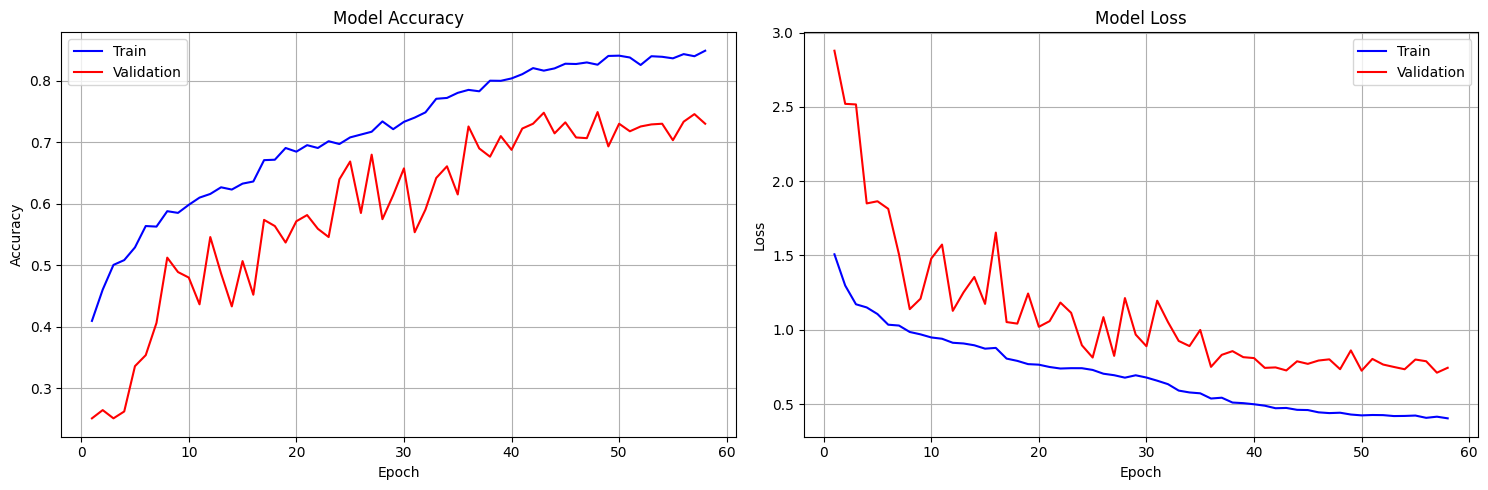

✅ Training history plotted


In [13]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

epochs_range = range(1, len(history.history['accuracy']) + 1)

# Accuracy
ax1.plot(epochs_range, history.history['accuracy'], 'b-', label='Train')
ax1.plot(epochs_range, history.history['val_accuracy'], 'r-', label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss
ax2.plot(epochs_range, history.history['loss'], 'b-', label='Train')
ax2.plot(epochs_range, history.history['val_loss'], 'r-', label='Validation')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300)
plt.show()

print("✅ Training history plotted")


# Save model

In [14]:
model_location = "WS5_V2.keras"
# Save final model
model.save(model_location)
print(f"✅ Model saved as {model_location}")

# Model size
import os
model_size = os.path.getsize(model_location) / (1024*1024)
print(f"Model size: {model_size:.2f} MB")





✅ Model saved as WS5_V2.keras
Model size: 309.13 MB
